In [49]:
import csv
import pandas as pd
from tqdm import tqdm
from requests.compat import urljoin
import requests
import glob
import os
import re
from bs4 import BeautifulSoup

In [50]:
!python --version

Python 3.10.9


In [51]:
pwd

'/home/stirunag/work/github/otar-maintenance/notebooks'

In [52]:
df = pd.read_csv('annotations_api/annotations_api_CD_GP_DS_OG_test.csv', sep = ',', names=['pmcid', 'section', 'sentence','ner_list', 'ner'])

In [53]:
def find_sub_span(token_span, entity_span):
    if token_span[0] < entity_span[1] and token_span[1] > entity_span[0]:
        return max(token_span[0], entity_span[0]), min(token_span[1], entity_span[1])
    return None

def convert2IOB(text_data, ner_tags):
    tokens = wordpunct_tokenize(text_data)
    # Compute the start and end positions for each token
    current_pos = 0
    token_spans = []
    for token in tokens:
        start = text_data.find(token, current_pos)
        end = start + len(token)
        token_spans.append((start, end))
        current_pos = end

    iob_tags = ['O'] * len(tokens)

    for start, end, entity, entity_type in sorted(ner_tags, key=lambda x: x[0]):
        entity_flag = False
        for i, token_span in enumerate(token_spans):
            if start <= token_span[0] < end:  # Adjusted condition for finding sub-span
                if not entity_flag:
                    iob_tags[i] = 'B-' + entity_type
                    entity_flag = True
                else:
                    iob_tags[i] = 'I-' + entity_type
            else:
                entity_flag = False

    # Validate tag sequence
    for i in range(1, len(iob_tags)):
        if iob_tags[i].startswith('I-') and iob_tags[i-1] == 'O':
            print(f"Invalid tag sequence at position {i} in sentence: {text_data}")
            # Optionally, handle the invalid sequence here

    return list(zip(tokens, iob_tags))


def convert2IOB_batch(docs, ner_tags_batch):
    results = []

    # Process the texts in batches using nlp.pipe
    for doc, ner_tags in zip(docs, ner_tags_batch):
        tokens = [token.text for token in doc]
        token_spans = [(token.idx, token.idx + len(token.text)) for token in doc]
        iob_tags = ['O'] * len(tokens)
        for start, end, entity, entity_type in sorted(ner_tags, key=lambda x: x[0]):
            entity_flag = False
            for i, token_span in enumerate(token_spans):
                if find_sub_span(token_span, (start, end)):
                    if not entity_flag:
                        iob_tags[i] = 'B-' + entity_type
                        entity_flag = True
                    elif iob_tags[i] == 'O':
                        iob_tags[i] = 'I-' + entity_type
                else:
                    entity_flag = False

        results.append(list(zip(tokens, iob_tags)))

    return results


In [54]:
import csv
import pathlib
from nltk.tokenize import wordpunct_tokenize 


In [55]:
def convert_to_IOB_format(data_file, output_folder, filename):
    df = pd.read_csv(data_file)

    # Convert 'ner' column string representation of list to actual list if it's not None
    data = [(row['sentence'], eval(row['ner']) if isinstance(row['ner'], str) and row['ner'] != "[]" else []) for index, row in df.iterrows()]

    # Ensure the output folder exists
    pathlib.Path(output_folder).mkdir(parents=True, exist_ok=True)
    result_path = os.path.join(output_folder, filename)

    with open(result_path, 'w', newline='\n') as f1:
        train_writer = csv.writer(f1, delimiter='\t', lineterminator='\n')

        # Process each sentence individually
        for sentence, ner_tags in data:
            iob_tags = convert2IOB(sentence, ner_tags)  # Convert to IOB format

            # Write the IOB-tagged tokens to the file
            for token, tag in iob_tags:
                train_writer.writerow([token, tag])
            train_writer.writerow([])  # Add an empty line after each sentence





In [56]:
output_folder = 'annotations_api/'
data_file = 'annotations_api/annotations_api_CD_GP_DS_OG_test.csv'
IOB_file_name = "annotations_api_test_IOB"
convert_to_IOB_format(data_file, output_folder,IOB_file_name)

In [57]:
from operator import add
from collections import namedtuple
from typing import List, Tuple, Dict
import csv
import logging

logger = logging.getLogger(__name__)
formatter = logging.Formatter('%(name)-12s: %(levelname)-8s %(message)s')

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)

logger.addHandler(ch)

Entity = namedtuple('Entity', ['span', 'tag'])
Entity_Label = namedtuple('Label', ['index', 'pos', 'tag'])


class MatchCount:
    """
    class to record the count of matching
    """
    def __init__(self, correct=0, incorrect=0, partial=0, missing=0, spurious=0):
        self.correct = correct
        self.incorrect = incorrect
        self.partial = partial
        self.missing = missing
        self.spurious = spurious

    def __eq__(self, other: 'MatchCount'):
        """
        check the equality by attribute values
        """
        if not isinstance(other, MatchCount):
            return NotImplemented
        isequal = self.correct == other.correct and self.incorrect == other.incorrect and \
            self.partial == other.partial and self.missing == other.missing and self.spurious == other.spurious
        return isequal

    def __add__(self, other: 'MatchCount'):
        """
        add two matching counts
        """
        if not isinstance(other, MatchCount):
            return NotImplemented
        correct = self.correct + other.correct
        incorrect = self.incorrect + other.incorrect
        partial = self.partial + other.partial
        missing = self.missing + other.missing
        spurious = self.spurious + other.spurious
        return MatchCount(correct=correct, incorrect=incorrect, partial=partial, missing=missing, spurious=spurious)

    def sum(self, gold: bool = True) -> int:
        """
        sum the relevant counts together
        :param gold: if the dataset is gold set
        :type gold: bool
        :return: ACT
        :rtype:
        """
        if gold:
            return self.correct + self.incorrect + self.missing + self.partial
        else:
            return self.correct + self.incorrect + self.spurious + self.partial

    def get_count(self) -> Tuple[int,int,int,int,int]:
        return self.correct, self.incorrect, self.partial, self.missing, self.spurious

    def __str__(self):
        return f"MatchCount: correct={self.correct}, incorrect={self.incorrect}, partial={self.partial}, " \
            f"missing={self.missing}, spurious={self.spurious}"


def has_overlap(gold: Entity, response: Entity) -> bool:
    """
    check whether the gold entity and the response entity overlap
    :param gold: gold entity
    :type gold: Entity
    :param response: response entity
    :type response: Entity
    :return: overlaps or not
    :rtype: bool
    """
    return gold.span[0] < response.span[1] and response.span[0] < gold.span[1]


def validate_label_seq(label_seq: List[str], ground_data: List[str] = None) -> bool:
    """
    Validate the label sequence of a sentence
    An invalid label sequence would be ['O', 'I-GP'] because an entity should start with 'B-'
    :param label_seq: a list of actual label sequence of a sentence
    :type label_seq: List[str]
    :param ground_data: tokens of a sentence
    :type ground_data: tokens of a sentence
    :return: True for valid label sequence
    :rtype: bool
    """
    # prohibited label sequence: 'O' -> 'I'
    prev_pos, prev_tag = ('O', 'O')
    for label in label_seq:
        if label == 'O':
            pos, tag = ('O', 'O')
        else:
            pos, tag = label.split('-')
            if pos not in ('B', 'I'):
                logger.warning(f'expect label starts with B or I but got: {label}')
                return False
        if pos == 'I':
            if prev_pos == 'O':
                logger.warning(f'invalid label sequence, I comes after O: {list(zip(label_seq, ground_data)) if ground_data else label_seq}')
                return False
            if prev_pos in ('B', 'I') and prev_tag != tag:
                logger.warning(f'invalid label sequence, tag inconsistent: {list(zip(label_seq, ground_data)) if ground_data else label_seq}')
                return False
        prev_pos, prev_tag = pos, tag
    return True


def extract_entity(seq: List[str], *args) -> List[Entity]:
    """
    extract entity from label sequence
    :param seq: a list of labels in a sentence
    :type seq: List[str
    :return: A list of entity object
    :rtype: List[Entity]
    """
    entities = []
    tmp = []

    for i, token in enumerate(seq):
        if token == 'O':
            pos, tag = 'O', 'O'
        else:
            pos, tag = token.split('-')
        label = Entity_Label(index=i, pos=pos, tag=tag)

        if pos == 'B' or pos == 'O':
            if tmp:
                entities.append(Entity(span=(tmp[0].index, i), tag=tmp[0].tag))
                tmp[:] = []
            if pos == 'B':
                tmp.append(label)
        elif pos == 'I':
            tmp.append(label)
    if tmp:
        entities.append(Entity(span=(tmp[0].index, tmp[-1].index+1), tag=tmp[0].tag))
    return entities


def agreement_sentence(entities_gold: List[Entity], entities_response: List[Entity]) -> \
        Tuple[MatchCount, MatchCount, MatchCount, MatchCount]:
    """
    calculate the correct, partial, missing and spurious entities between gold and response entities
    :param entities_gold: A list of entities from gold labels of a sentence
    :type entities_gold: List[Entity]
    :param entities_response: A list of entities from response labels of a sentence
    :type entities_response: List[Entity]
    :return: A tuple of match counts: [correct_total, partial_total, missing_total, incorrect_total, spurious_total]
    :rtype: Tuple[int, int, int, int, int]
    """
    strict = MatchCount()
    exact_boundary = MatchCount()
    partial_boundary = MatchCount()
    type_matching = MatchCount()

    missing_count_gold = [True for _ in range(len(entities_gold))]
    spurious_count_resp = [True for _ in range(len(entities_response))]

    for i, annoA in enumerate(entities_gold):
        for j, annoB in enumerate(entities_response):
            if has_overlap(annoA, annoB):
                missing_count_gold[i] = False
                spurious_count_resp[j] = False

                # type matching: check overlap and type
                if annoA.tag == annoB.tag:
                    type_matching.correct += 1
                else:
                    type_matching.incorrect += 1

                if annoA.span == annoB.span:
                    # boundary match: check exact boundary
                    exact_boundary.correct += 1
                    partial_boundary.correct += 1
                    # strict match: boundary ok and check type
                    if annoA.tag == annoB.tag:
                        strict.correct += 1
                    else:
                        strict.incorrect += 1
                else:
                    # strict: boundary not exact match
                    strict.incorrect += 1
                    # exact boundary match: boundary not exact match
                    exact_boundary.incorrect += 1
                    # partial match: partial match
                    partial_boundary.partial += 1

    missing = sum(missing_count_gold)
    spurious = sum(spurious_count_resp)
    # print(spurious_count_resp)

    strict.missing, exact_boundary.missing, partial_boundary.missing, type_matching.missing = [missing]*4
    strict.spurious, exact_boundary.spurious, partial_boundary.spurious, type_matching.spurious = [spurious]*4

    return strict, exact_boundary, partial_boundary, type_matching


def agreement_dataset(gold: List[List[str]], response: List[List[str]],
                      validate_label: bool = True, X: List[List[str]] = None) -> Tuple[List[MatchCount], int, int]:
    """
    clacuate the agreement between gold set and response set
    :param gold: A list of label sequence of sentences from gold set
    :type gold: List[List[str]]
    :param response: A list of label sequence of sentences from response set
    :type response: List[List[str]]
    :param validate_label: if True, validate the label sequence
    :type validate_label: bool
    :param x: A list of text sequences
    :type X: List[List[str]]
    :return: A tuple of match counts and total counts:
    [correct_total, partial_total, missing_total, incorrect_total, spurious_total], gold_total, resp_total
    :rtype: Tuple[List[MatchCount], int, int]
    """
    assert len(gold) == len(response), f"expect {len(gold)} sentences but got {len(response)} sentences " \
        f"in response dataset"
    dataset_agreement = [MatchCount()]*4
    gold_ent_count = 0
    resp_ent_count = 0
    for i, label_seq_gold in enumerate(gold):
        if validate_label:
            if X:
                ground_data = X[i]
            else:
                ground_data = None
            assert validate_label_seq(label_seq_gold, ground_data), f"sent {i}: invalid gold label sequence\n"
            # assert validate_label_seq(response[i], ground_data), f"sent {i}: invalid response label sequence\n"
            validate_label_seq(response[i], ground_data)

        entities_gold = extract_entity(label_seq_gold, i, 'gold')
        entities_resp = extract_entity(response[i], i, 'response')

        gold_ent_count += len(entities_gold)
        resp_ent_count += len(entities_resp)

        sent_agreement = agreement_sentence(entities_gold, entities_resp)
        dataset_agreement = list(map(add, dataset_agreement, sent_agreement))
    return dataset_agreement, gold_ent_count, resp_ent_count


def evaluate(agreement: MatchCount, beta: float = 1.0) -> Tuple[float, float, float]:
    """
    calculate the precision, recall and f1 score based on agreement
    :param agreement: A tuple of match counts:
    [correct_total, partial_total, missing_total, incorrect_total, spurious_total]
    :type agreement: Tuple[int, int, int, int, int]
    :param beta: beta is chosen such that recall is considered beta times as important as precision
    :type beta: float
    :return: precision, recall, f1 score
    :rtype: Tuple[float, float, float]
    """
    p = precision_score(correct=agreement.correct,
                        incorrect=agreement.incorrect,
                        partial=agreement.partial,
                        spurious=agreement.spurious)
    r = recall_score(correct=agreement.correct,
                     incorrect=agreement.incorrect,
                     partial=agreement.partial,
                     missing=agreement.missing)
    f1 = f1_score(precision=p, recall=r, beta=beta)
    return p, r, f1


def semeval_scores(gold: List[List[str]], response: List[List[str]], digits: int = 3,
                   validate_label: bool = True, X: List[List[str]] = None) -> Dict[str, List]:
    """
    calculate the precision, recall and f1 score based on agreement
    :param gold: A list of label sequence of sentences from gold set
    :type gold: List[List[str]]
    :param response: A list of label sequence of sentences from response set
    :type response: List[List[str]]
    :param digits: Number of digits for formatting output floating point values
    :type digits: int
    :param validate_label: if True, validate the label sequence
    :type validate_label: bool
    :param X: A list of text sequences
    :type X: List[List[str]]
    :return: precision, recall, f1 score
    :rtype: Tuple[float, float, float]
    """
    match_counts = agreement_dataset(gold=gold, response=response, validate_label=validate_label, X=X)
    scores = {}
    for name, agree in zip(('strict', 'exact', 'partial', 'type'), match_counts):
        p, r, f1 = evaluate(agree)
        scores[name] = [round(p, digits), round(r, digits), round(f1, digits)]
    return scores


def semeval_scores_report(gold: List[List[str]], response: List[List[str]], digits: int = 2,
                          validate_label: bool = True, X: List[List[str]] = None) -> str:
    """
    calculate the precision, recall and f1 score based on agreement and generate a report
    :param gold: A list of label sequence of sentences from gold set
    :type gold: List[List[str]]
    :param response: A list of label sequence of sentences from response set
    :type response: List[List[str]]
    :param digits: Number of digits for formatting output floating point values
    :type digits: int
    :param validate_label: if True, validate the label sequence
    :type validate_label: bool
    :param X: A list of text sequences
    :type X: List[List[str]]
    :return: formatted report
    :rtype: str
    """
    match_counts, gold_ent_count, resp_ent_count = agreement_dataset(gold=gold, response=response,
                                                                     validate_label=validate_label, X=X)
    HEADERS = ('strict', 'exact', 'partial', 'type')
    SEMEVAL_NAMES = ('correct', 'incorrect', 'partial', 'missing', 'spurious')

    strict_counts, exact_counts, partial_counts, type_counts = (count.get_count() for count in match_counts)
    strict_scores, exact_scores, partial_scores, type_scores = (evaluate(agreement) for agreement in match_counts)

    rows = zip(SEMEVAL_NAMES, strict_counts, exact_counts, partial_counts, type_counts)
    longest_last_line_heading = 'Gold Total'
    name_width = max(len(cn) for cn in SEMEVAL_NAMES)
    width = max(name_width, len(longest_last_line_heading), digits)
    head_fmt = '{:>{width}s} ' + ' {:>9}' * len(HEADERS)
    report = head_fmt.format('', *HEADERS, width=width)
    report += '\n\n'
    row_fmt_score = '{:>{width}s} ' + ' {:>9.{digits}f}' * 4 + '\n'
    row_fmt_count = '{:>{width}s} ' + ' {:>9,d}' * 4 + '\n'
    row_fmt_ent = '{:>{width}s} ' + ' {:>9,d}' + '\n'

    row_str_len = 0
    for row in rows:
        report += row_fmt_count.format(*row, width=width)
        row_str_len = len(row_fmt_count.format(*row, width=width))
    report += '='*row_str_len + '\n'
    rows = zip(('precision', 'recall', 'f1 score'), strict_scores, exact_scores, partial_scores, type_scores)
    for row in rows:
        report += row_fmt_score.format(*row, width=width, digits=digits)
    report += '='*row_str_len + '\n'
    rows = (('Gold Total', gold_ent_count), ('Resp Total', resp_ent_count))
    for row in rows:
        report += row_fmt_ent.format(*row, width=width)
    report += '\n'
    return report


def precision_score(correct: int, incorrect: int, partial: int, spurious: int) -> float:
    """
    the denominator is the total number of entities produced by the system
    the equation used:
    ACT = COR + INC + PAR + SPU = TP + FP
    P = COR/ACT = TP/(TP+FP)
    if partial match allowed:
    P = (COR + 0.5*PAR)/ACT

    :param correct: number of gold entities exactly matched by response
    :type correct: int
    :param incorrect: number of gold entities wrongly annotated (wrong type) by response
    :type incorrect: int
    :param partial: number of gold entities partially annotated (same type and overlaps) by response
    :type partial: int
    :param spurious: number of response entities not in the gold entities
    :type spurious: int
    :return: precision score
    :rtype: float
    """
    numerator = correct + 0.5*partial
    # A easier way to calculate denominator is by counting number of entities in response
    # thus we dont need to count missing, incorrect and spurious
    denominator = correct + incorrect + partial + spurious
    return numerator/denominator


def recall_score(correct: int, incorrect: int, partial: int, missing: int) -> float:
    """
    the denominator is the total number of entities in the gold data
    the equation used:

    POS = COR + INC + PAR + MIS = TP + FN
    R = COR/POS = TP/(TP+FN)
    if partial match allowed:
    R = (COR + 0.5*PAR)/POS

    :param correct: number of gold entities exactly matched by response
    :type correct: int
    :param incorrect: number of gold entities wrongly annotated (wrong type) by response
    :type incorrect: int
    :param partial: number of gold entities partially annotated (same type and overlaps) by response
    :type partial: int
    :param missing: number of gold entities not in the response entities
    :type missing: int
    :return: recall score
    :rtype: int
    """
    numerator = correct + 0.5*partial
    # A easier way to calculate denominator is by counting number of entities in gold
    # thus we dont need to count missing, incorrect and spurious
    denominator = correct + incorrect + partial + missing
    return numerator/denominator


def f1_score(precision: float, recall: float, beta: float = 1.0) -> float:
    """
    calculate f1 score given precision and recall score
    the equation used (beta f1 score):

    F1 = (1+ beta**2) * (precision*recall) / ((beta**2)*precision + recall)
    where beta is chosen such taht recall is considered beta times as important as precision

    if beta = 1:
    F1 = 2*precision*recall/(precision+recall)

    :param precision: precision score
    :type precision: float
    :param recall: recall score
    :type recall: float
    :param beta: beta is chosen such that recall is considered beta times as important as precision,
    :type beta: float
    :return: f1 score
    :rtype: float
    """
    numerator = (beta**2 + 1)*precision * recall
    denominator = (beta**2)*precision + recall
    return numerator/denominator


def load_IOBdataset(data_path: str, targets: List[str] = None) -> Tuple[List[List[str]], List[List[str]]]:
    """
    load the IOB dataset, which is in csv format
    :param data_path: path to the csv file of IOB dataset
    :type data_path: str
    :param targets: a list of interest types
    :type targets: List[str]
    :return: list of labels of every sentence in dataset
    :rtype: List[List[str
    """
    X = []
    y = []

    X_sent = []
    y_sent = []
    with open(data_path, 'r', encoding='utf-8') as f:
        csv_reader = csv.reader(f, delimiter='\t')
        for line in csv_reader:
            if line:
                token, tag = line[0], line[-1]
                X_sent.append(token)
                if targets:
                    if tag.split('-')[-1] in set(targets):
                        y_sent.append(tag)
                    else:
                        y_sent.append('O')
                else:
                    y_sent.append(tag)
            else:
                # we reach the end of a sentence
                if len(X_sent) > 0:
                    X.append(X_sent)
                    y.append(y_sent)
                X_sent = []
                y_sent = []
    return X, y


def semeval_report(gold_path: str, response_path: str, targets: List[str] = None,
                   digits: int = 2, validate_label: bool = True) -> str:
    """
    report semeval scores by providing file paths to gold and response datasets
    :param gold_path: path to gold dataset file
    :type gold_path: str
    :param response_path: path to response dataset file
    :type response_path: str
    :param targets: a list of interest types
    :type targets: List[str]
    :param digits: Number of digits for formatting output floating point values
    :type digits: int
    :param validate_label: if True, validate the label sequence
    :type validate_label: bool
    :return: semeval scores report
    :rtype: str
    """
    gold_data, gold_labels = load_IOBdataset(gold_path, targets=targets)
    _, resp_labels = load_IOBdataset(response_path, targets=targets)

    if validate_label:
        X = gold_data
    else:
        X = None
    return semeval_scores_report(gold=gold_labels, response=resp_labels, digits=digits,
                                 validate_label=validate_label, X=X)


In [58]:
data_path = output_folder+IOB_file_name
all_tags = ['GP', 'DS', 'OG', 'CD']
ml_path = output_folder+'test.tsv'


for each_tag in all_tags:
    print('############ '+each_tag+' ####################')
    print('\n')
    print(semeval_report(gold_path=data_path, response_path=ml_path, targets=[each_tag]))

############ GP ####################


               strict     exact   partial      type

   correct      3,003     3,003     3,003     3,150
 incorrect        147       147         0         0
   partial          0         0       147         0
   missing      1,132     1,132     1,132     1,132
  spurious      3,420     3,420     3,420     3,420
 precision       0.46      0.46      0.47      0.48
    recall       0.70      0.70      0.72      0.74
  f1 score       0.55      0.55      0.57      0.58
Gold Total      4,282
Resp Total      6,566


############ DS ####################


               strict     exact   partial      type

   correct      1,030     1,030     1,030     1,129
 incorrect         99        99         0         0
   partial          0         0        99         0
   missing        393       393       393       393
  spurious      1,218     1,218     1,218     1,218
 precision       0.44      0.44      0.46      0.48
    recall       0.68      0.68      0.71 

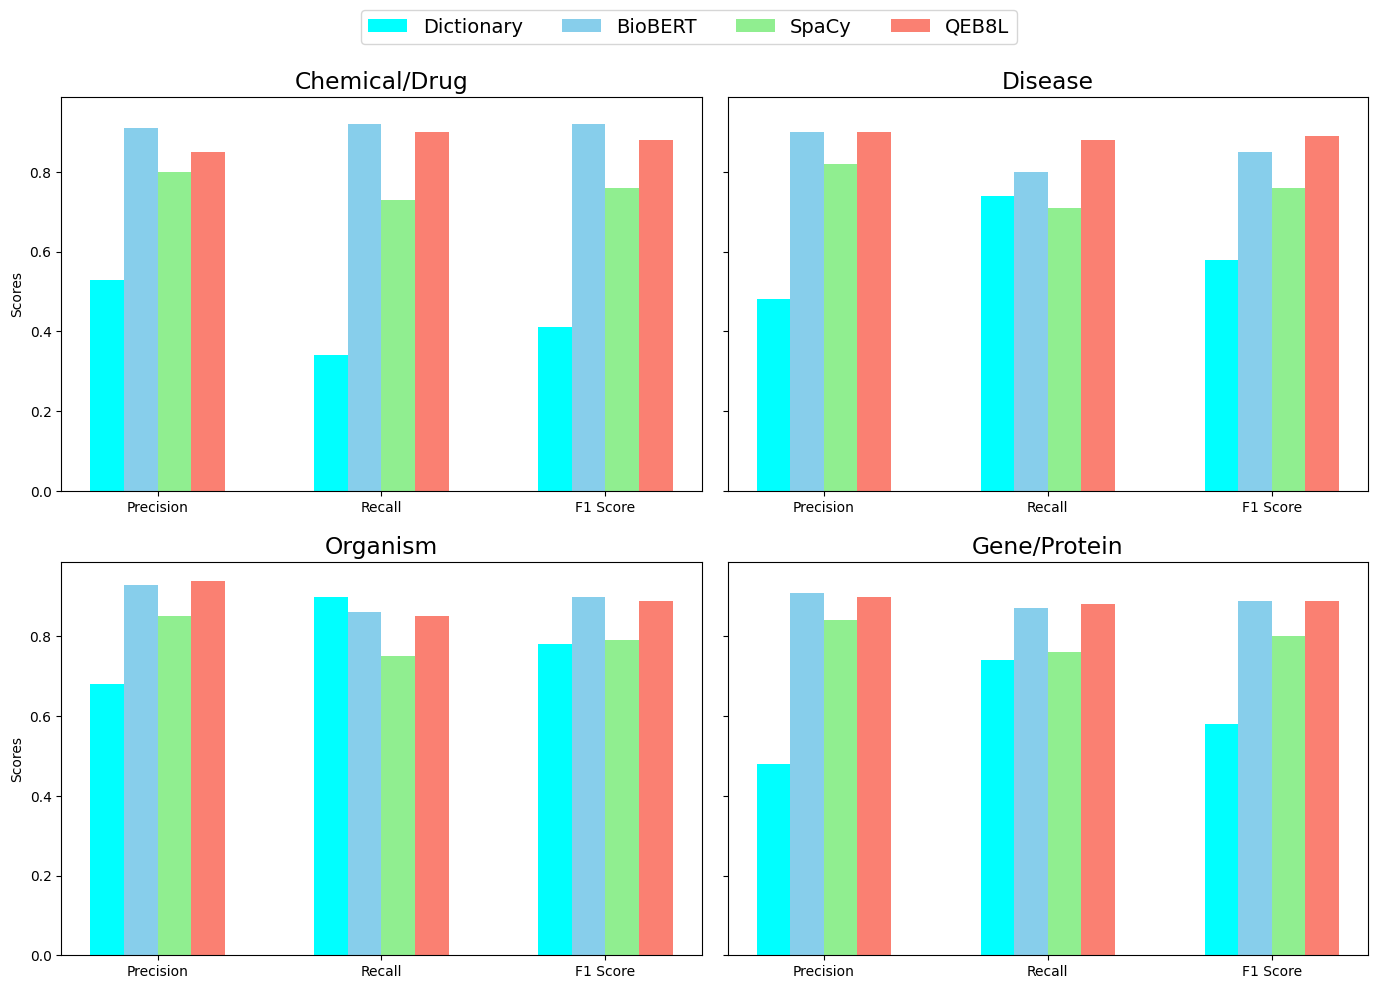

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
categories = ['Precision', 'Recall', 'F1 Score']
dictionary_chemical = [0.53, 0.34, 0.41]
bioBERT_chemical = [0.91, 0.92, 0.92]
spacy_chemical = [0.8, 0.73, 0.76]
QEB8L_chemical = [0.85, 0.9, 0.88]

dictionary_disease = [0.48, 0.74, 0.58]
bioBERT_disease = [0.9, 0.8, 0.85]
spacy_disease = [0.82, 0.71, 0.76]
QEB8L_disease = [0.9, 0.88, 0.89]

dictionary_organism = [0.68, 0.90, 0.78]
bioBERT_organism = [0.93, 0.86, 0.9]
spacy_organism = [0.85, 0.75, 0.79]
QEB8L_organism = [0.94, 0.85, 0.89]

dictionary_gene_protein = [0.48, 0.74, 0.58]
bioBERT_gene_protein = [0.91, 0.87, 0.89]
spacy_gene_protein = [0.84, 0.76, 0.8]
QEB8L_gene_protein = [0.9, 0.88, 0.89]

x = np.arange(len(categories))  # the label locations
width = 0.15  # the width of the bars, adjusted to prevent overlap

fig, ax = plt.subplots(2, 2, figsize=(14, 10), sharey=True)  # Share y-axis for consistency

# Setup for increased font size to match scientific article standards
plt.rcParams.update({'font.size': 14})  # Updating font size globally

# Function to create bars for subplots
def create_bars(ax, offset, data, label, color):
    return ax.bar(x + offset, data, width, label=label, color=color)

# Chemical/Drug subplot
create_bars(ax[0, 0], -1.5*width, dictionary_chemical, 'Dictionary', 'cyan')
create_bars(ax[0, 0], -0.5*width, bioBERT_chemical, 'BioBERT', 'skyblue')
create_bars(ax[0, 0], 0.5*width, spacy_chemical, 'SpaCy', 'lightgreen')
create_bars(ax[0, 0], 1.5*width, QEB8L_chemical, 'QEB8L', 'salmon')
ax[0, 0].set_ylabel('Scores')
ax[0, 0].set_title('Chemical/Drug')
ax[0, 0].set_xticks(x)
ax[0, 0].set_xticklabels(categories)

# Disease subplot
create_bars(ax[0, 1], -1.5*width, dictionary_disease, 'Dictionary', 'cyan')
create_bars(ax[0, 1], -0.5*width, bioBERT_disease, 'BioBERT', 'skyblue')
create_bars(ax[0, 1], 0.5*width, spacy_disease, 'SpaCy', 'lightgreen')
create_bars(ax[0, 1], 1.5*width, QEB8L_disease, 'QEB8L', 'salmon')
ax[0, 1].set_title('Disease')
ax[0, 1].set_xticks(x)
ax[0, 1].set_xticklabels(categories)

# Organism subplot
create_bars(ax[1, 0], -1.5*width, dictionary_organism, 'Dictionary', 'cyan')
create_bars(ax[1, 0], -0.5*width, bioBERT_organism, 'BioBERT', 'skyblue')
create_bars(ax[1, 0], 0.5*width, spacy_organism, 'SpaCy', 'lightgreen')
create_bars(ax[1, 0], 1.5*width, QEB8L_organism, 'QEB8L', 'salmon')
ax[1, 0].set_ylabel('Scores')
ax[1, 0].set_title('Organism')
ax[1, 0].set_xticks(x)
ax[1, 0].set_xticklabels(categories)

# Gene/Protein subplot
create_bars(ax[1, 1], -1.5*width, dictionary_gene_protein, 'Dictionary', 'cyan')
create_bars(ax[1, 1], -0.5*width, bioBERT_gene_protein, 'BioBERT', 'skyblue')
create_bars(ax[1, 1], 0.5*width, spacy_gene_protein, 'SpaCy', 'lightgreen')
create_bars(ax[1, 1], 1.5*width, QEB8L_gene_protein, 'QEB8L', 'salmon')
ax[1, 1].set_title('Gene/Protein')
ax[1, 1].set_xticks(x)
ax[1, 1].set_xticklabels(categories)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rectangle to fit the legend

# Add a single legend
fig.legend(['Dictionary', 'BioBERT', 'SpaCy', 'QEB8L'], loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1))

# Show plot
plt.show()

# Save the figure
fig.savefig('annotations_api/comparison_plot.png', format='png', bbox_inches='tight')


In [60]:
# Calculate improvements
QEB8L_scores = {
    'chemical': [0.85, 0.9, 0.88],
    'disease': [0.9, 0.88, 0.89],
    'organism': [0.94, 0.85, 0.89],
    'gene_protein': [0.9, 0.88, 0.89]
}

dictionary_scores = {
    'chemical': [0.53, 0.34, 0.41],
    'disease': [0.48, 0.74, 0.58],
    'organism': [0.68, 0.90, 0.78],
    'gene_protein': [0.48, 0.74, 0.58]
}

improvements = {category: [QEB8L - dictionary for QEB8L, dictionary in zip(QEB8L_scores[category], dictionary_scores[category])] 
                for category in QEB8L_scores}

improvements

{'chemical': [0.31999999999999995, 0.56, 0.47000000000000003],
 'disease': [0.42000000000000004, 0.14, 0.31000000000000005],
 'organism': [0.2599999999999999, -0.050000000000000044, 0.10999999999999999],
 'gene_protein': [0.42000000000000004, 0.14, 0.31000000000000005]}

These results indicate that the quantized model (QEB8L) generally performs significantly better than the dictionary-based approach across most metrics and categories. The most notable improvements are seen in Precision and F1 Score across all categories, with substantial gains especially in Recall for the Chemical/Drug category. However, it's important to note the slight decrease in Recall for the Organism category, suggesting that the quantized model might prioritize precision over recall in some instances.

In [61]:
# Calculate the average scores for Precision (P), Recall (R), and F1 Score (F) across all categories for both QEB8L and Dictionary approaches
average_scores_QEB8L = [sum(scores) / len(scores) for scores in zip(*QEB8L_scores.values())]
average_scores_dictionary = [sum(scores) / len(scores) for scores in zip(*dictionary_scores.values())]

average_scores = {
    'QEB8L': average_scores_QEB8L,
    'Dictionary': average_scores_dictionary
}

average_scores


{'QEB8L': [0.8975, 0.8775, 0.8875000000000001],
 'Dictionary': [0.5425, 0.6799999999999999, 0.5875]}

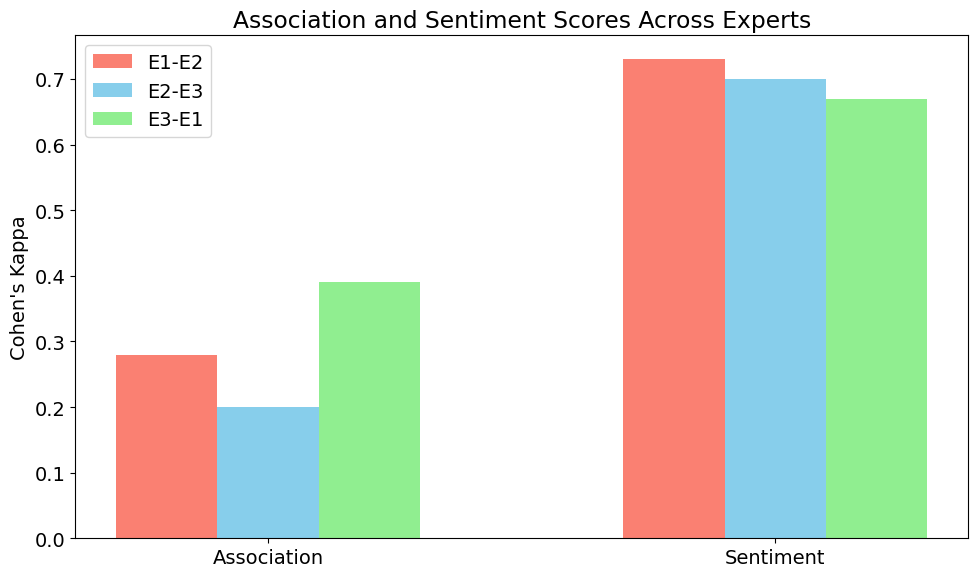

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
categories = ['Association', 'Sentiment']
values = {
    'E1-E2': [0.28, 0.73],
    'E2-E3': [0.2, 0.7],
    'E3-E1': [0.39, 0.67]
}

x = np.arange(len(categories))  # the label locations
width = 0.2  # the width of the bars, adjusted to prevent overlap

fig, ax = plt.subplots(figsize=(10, 6))  # Setup for the figure

# Colors from the previous plot
colors = ['salmon', 'skyblue', 'lightgreen']

# Function to create bars for the plot
def create_bars(offset, data, label, color):
    return ax.bar(x + offset*width, data, width, label=label, color=color)

# Creating bars for each entity
offsets = np.array([-1, 0, 1])  # To center the bars around the category labels
for i, (label, data) in enumerate(values.items()):
    create_bars(offsets[i], data, label, colors[i])

ax.set_ylabel('Cohen\'s Kappa')
ax.set_title('Association and Sentiment Scores Across Experts')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# Save the figure
fig.savefig('annotations_api/E_comparison_plot.png', format='png', bbox_inches='tight')


In [63]:
# !pip install matplotlib_venn

In [64]:
import pandas as pd
from itertools import combinations
# Load the files
quantised_predictions_path = 'annotations_api/quantised_predictions_iob_2.csv'
annotations_api_path = 'annotations_api/annotations_api_test_IOB'
test_path = 'annotations_api/test.tsv'


quantised_predictions_df = pd.read_csv(quantised_predictions_path, sep='\t', names=['Token', 'Tag'], quoting=3)
annotations_api_df = pd.read_csv(annotations_api_path, sep='\t', names=['Token', 'Tag'], quoting=3)
test_df = pd.read_csv(test_path, sep='\t', names=['Token', 'Tag'], quoting=3)

# Check the first few rows again to ensure they're loaded correctly
quantised_predictions_df.head(), annotations_api_df.head(), test_df.head()



(                       Token   Tag
 0                          A     O
 1                    subunit     O
 2                         of     O
 3                        the     O
 4  oligosaccharyltransferase  B-GP,
                        Token Tag
 0                          A   O
 1                    subunit   O
 2                         of   O
 3                        the   O
 4  oligosaccharyltransferase   O,
                        Token   Tag
 0                          A     O
 1                    subunit     O
 2                         of     O
 3                        the     O
 4  oligosaccharyltransferase  B-GP)

In [65]:
def extract_words_by_tags(df, tags):
    return df[df['Tag'].isin(tags)][['Token', 'Tag']]
    
# define tags of interest
tags_of_interest = ['B-GP', 'I-GP', 'B-CD', 'I-CD', 'B-DS', 'I-DS', 'B-OG', 'I-OG']

# Re-extract words by tags for each dataframe
quantised_words = extract_words_by_tags(quantised_predictions_df, tags_of_interest)
annotations_api_test_words = extract_words_by_tags(annotations_api_df, tags_of_interest)
test_words= extract_words_by_tags(test_df, tags_of_interest)

# Show sample of extracted words for each file
quantised_words.head(), annotations_api_test_words_corrected.head(), test_words_corrected.head()

(                         Token   Tag
 4    oligosaccharyltransferase  B-GP
 13                 Arabidopsis  B-OG
 22                       Plant  B-OG
 80                       plant  B-OG
 134                Arabidopsis  B-OG,
            Token   Tag
 50        Panama  B-OG
 134  Arabidopsis  B-OG
 135     thaliana  I-OG
 169            A  B-OG
 170            .  I-OG,
                         Token   Tag
 4   oligosaccharyltransferase  B-GP
 13                Arabidopsis  B-OG
 22                      Plant  B-OG
 46                      Plant  B-OG
 80                      plant  B-OG)

In [66]:
from collections import defaultdict

def group_entities(df):
    entities_dict = defaultdict(lambda: {'set': set(), 'list': []})
    current_entity = ""
    current_tag = ""

    for index, row in df.iterrows():
        word, tag = row['Token'], row['Tag']
        tag_type = tag.split('-')[-1]  # Extract tag type (GP, CD, DS, OG)
        
        if tag.startswith('B-'):
            # Add previous entity to dict before starting a new one
            if current_entity:
                entities_dict[current_tag]['set'].add(current_entity)
                entities_dict[current_tag]['list'].append(current_entity)
            current_entity = word  # Start new entity
        elif tag.startswith('I-') and current_entity:
            current_entity += " " + word  # Append to current entity
        else:
            # Non-entity or new entity starting without I- continuation
            if current_entity:
                entities_dict[current_tag]['set'].add(current_entity)
                entities_dict[current_tag]['list'].append(current_entity)
                current_entity = ""  # Reset for next entity
        current_tag = tag_type

    # Add the last entity if exists
    if current_entity:
        entities_dict[current_tag]['set'].add(current_entity)
        entities_dict[current_tag]['list'].append(current_entity)

    return entities_dict

# Group entities for each DataFrame
quantised_entities = group_entities(quantised_words)
annotations_api_test_entities = group_entities(annotations_api_test_words)
test_entities = group_entities(test_words)

# Preview one of the categories to verify
list(quantised_entities['GP']['set'])[:5], list(quantised_entities['GP']['list'])[:5]

(['glucose - 1 - phosphate adenylyltransferase',
  'HFE',
  'GTR',
  'C reactive protein',
  'Csr'],
 ['oligosaccharyltransferase', 'ARTUMES', 'ARU', 'ARU', 'ARU'])

In [67]:
# from matplotlib_venn import venn2
# import matplotlib.pyplot as plt

# def prepare_venn_data(entity_counts):
#     return {'10': entity_counts[0], '01': entity_counts[1], '11': entity_counts[2]}

# def calculate_venn_counts(set_a, set_b):
#     unique_to_a = len(set_a - set_b)
#     unique_to_b = len(set_b - set_a)
#     intersection = len(set_a & set_b)
#     return unique_to_a, unique_to_b, intersection
    
# # Generating Venn diagrams for all entities in a 2x4 subplot layout
# fig, ax = plt.subplots(2, 4, figsize=(20, 10))

# # Entities to compare
# entities = ['GP', 'CD', 'DS', 'OG']

# # Generate Venn diagrams for Quantised vs Test
# for i, entity in enumerate(entities):
#     counts = calculate_venn_counts(quantised_entities[entity]['set'], test_entities[entity]['set'])
#     venn_data = prepare_venn_data(counts)
#     venn2(subsets=(venn_data['10'], venn_data['01'], venn_data['11']), 
#           set_labels=('QEB8L', 'Gold Standard'), 
#           set_colors=(colors['Dictionary'], colors['QEB8L']),
#           alpha=0.5,
#           ax=ax[0, i])
#     ax[0, i].set_title(f'{entity} Entities (Quantised vs. Test)')

# # Generate Venn diagrams for Annotations API vs Test
# for i, entity in enumerate(entities):
#     counts = calculate_venn_counts(annotations_api_test_entities[entity]['set'], test_entities[entity]['set'])
#     venn_data = prepare_venn_data(counts)
#     venn2(subsets=(venn_data['10'], venn_data['01'], venn_data['11']), 
#           set_labels=('Dictionary', 'Gold Standard'), 
#           set_colors=(colors['Dictionary'], colors['QEB8L']),
#           alpha=0.5,
#           ax=ax[1, i])
#     ax[1, i].set_title(f'{entity} Entities (Annotations API vs. Test)')

# plt.tight_layout()
# plt.show()


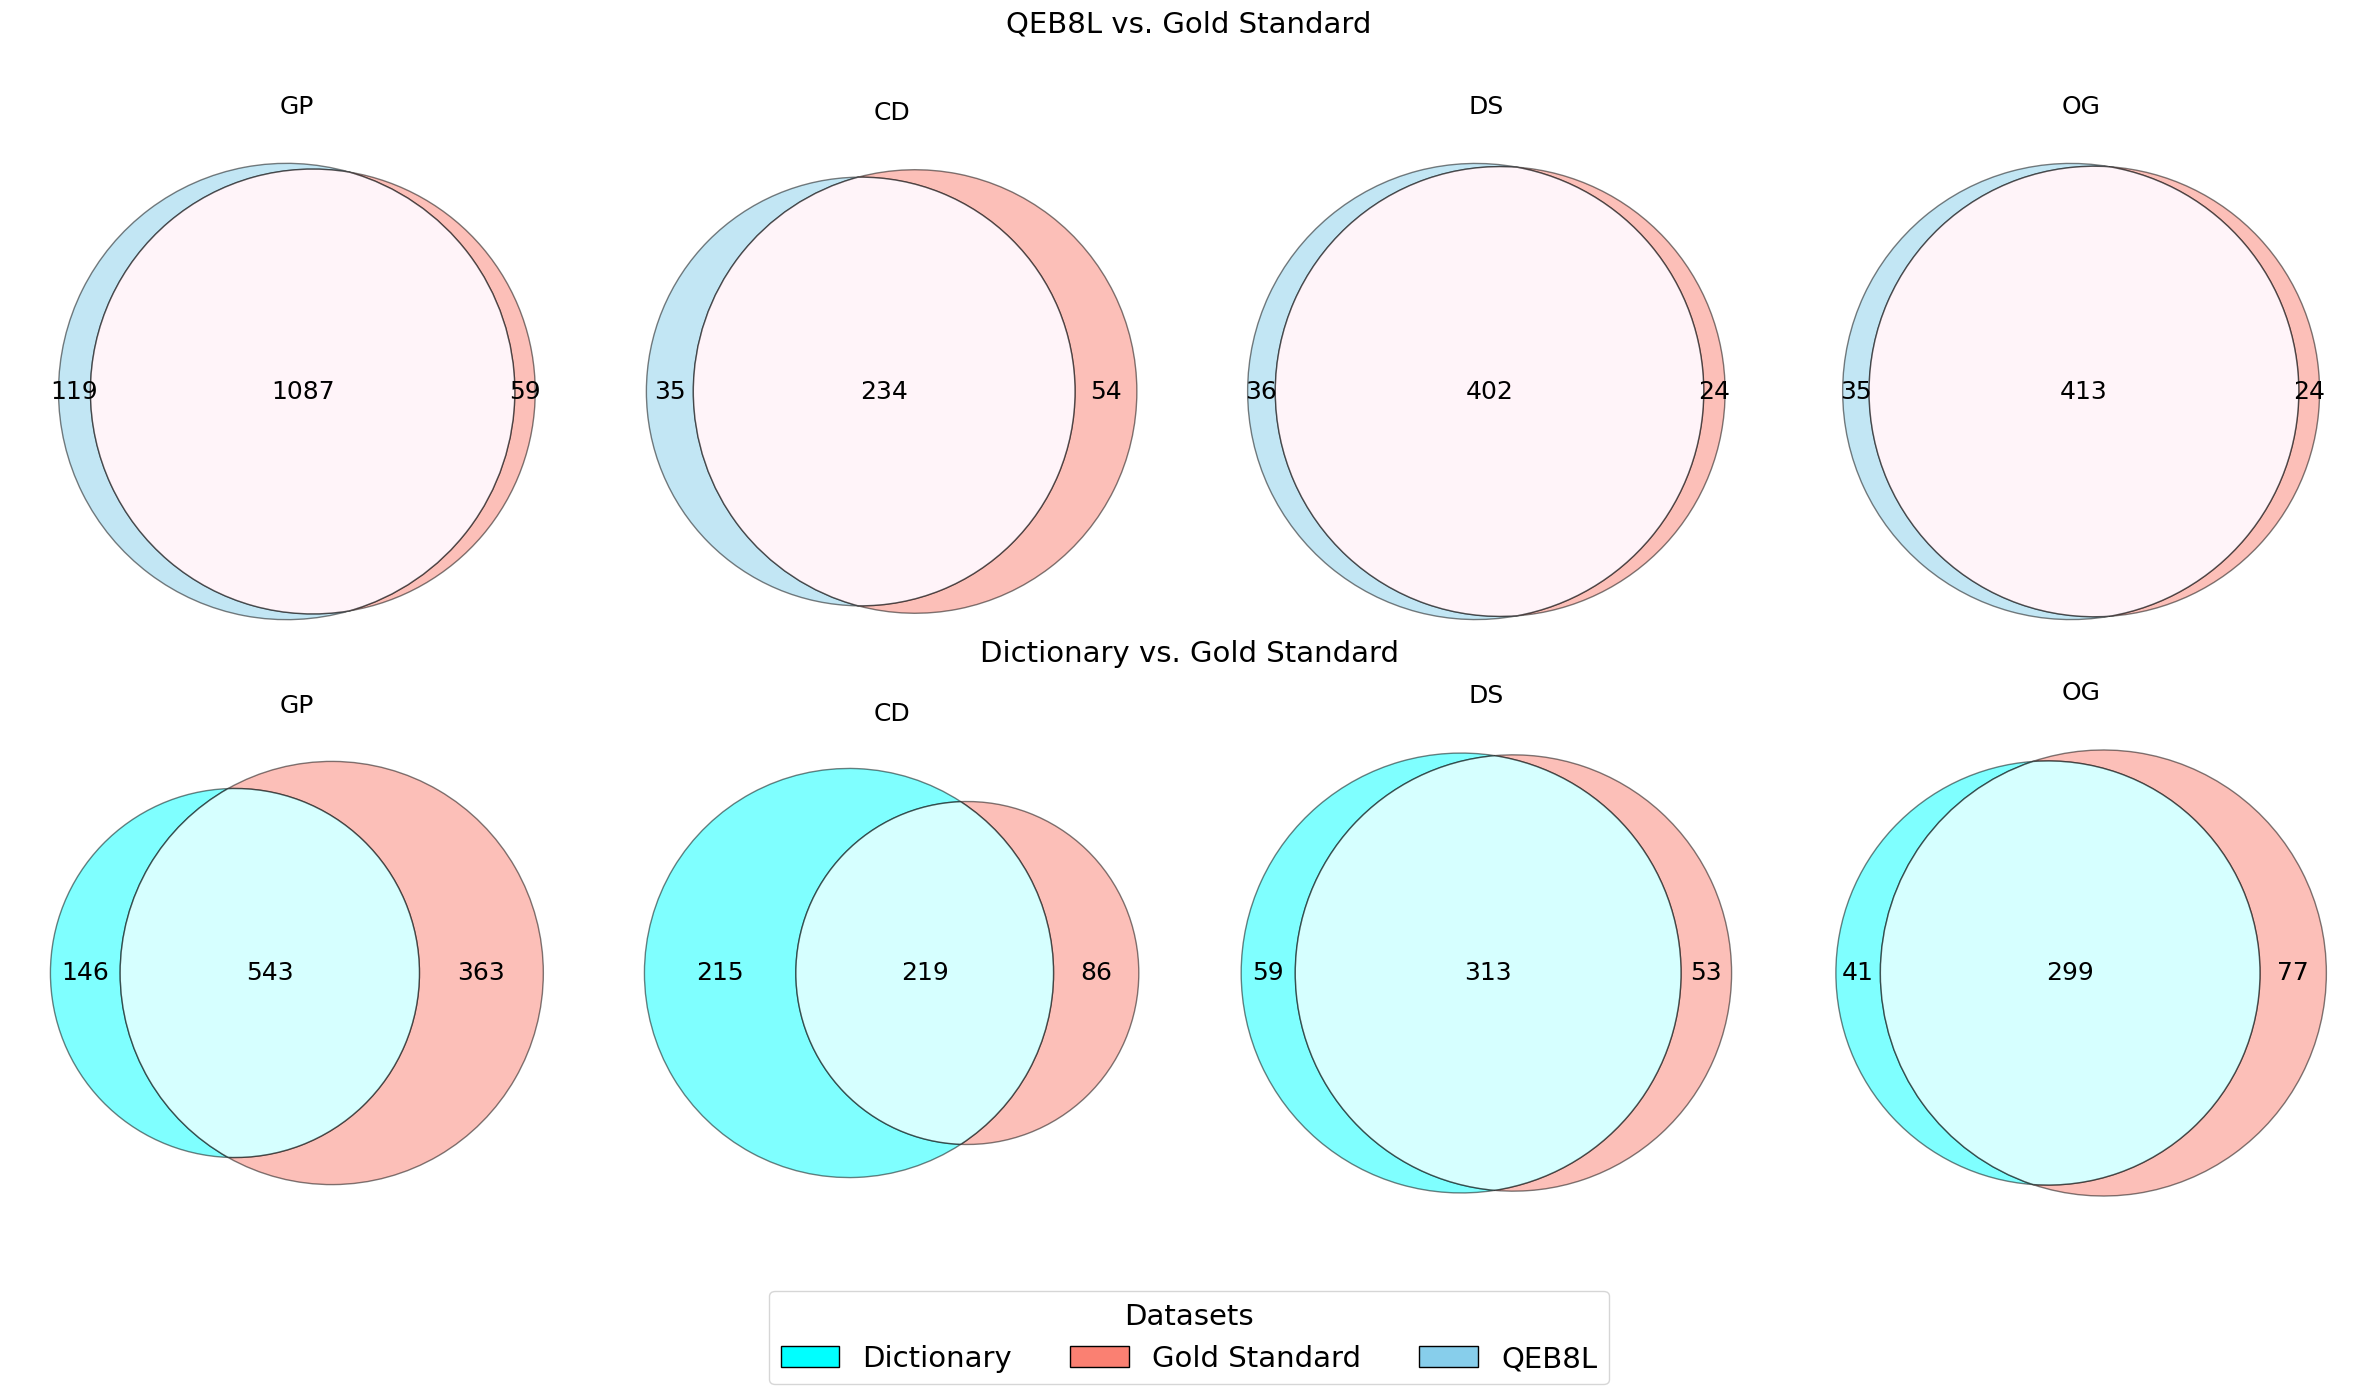

In [68]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib.patches import Patch

# Update colors based on your specifications
colors = {
    'Dictionary': 'cyan',
    'Gold Standard': 'salmon',
    'QEB8L': 'skyblue'
}

# Generating Venn diagrams for all entities in a 2x4 subplot layout with partial matches
fig, ax = plt.subplots(2, 4, figsize=(24, 14))

# Adding titles for the two rows to differentiate the comparison sets
fig.text(0.5, 0.98, "QEB8L vs. Gold Standard", ha='center', fontsize=21)

# Generate Venn diagrams for Quantised vs Test with partial match logic
for i, entity in enumerate(entities):
    counts = calculate_venn_counts(quantised_entities[entity]['set'], test_entities[entity]['set'])
    venn_data = prepare_venn_data(counts)
    venn = venn2(subsets=(venn_data['10'], venn_data['01'], venn_data['11']), 
                 set_labels=('', ''),  # Labels removed for subplot titles
                 set_colors=(colors['QEB8L'], colors['Gold Standard']),
                 alpha=0.5,
                 ax=ax[0, i])
    ax[0, i].set_title(f'{entity}', fontsize=18)
    venn.get_patch_by_id('10').set_edgecolor('black')
    venn.get_patch_by_id('01').set_edgecolor('black')
    venn.get_patch_by_id('11').set_edgecolor('black')
    venn.get_label_by_id('10').set_fontsize(18)  # Adjust font size for count labels
    venn.get_label_by_id('01').set_fontsize(18)
    venn.get_label_by_id('11').set_fontsize(18)

fig.text(0.5, 0.53, "Dictionary vs. Gold Standard", ha='center', fontsize=21)

plt.subplots_adjust(hspace=0.8)  # 
# Generate Venn diagrams for Annotations API vs Test with partial match logic
for i, entity in enumerate(entities):
    counts = calculate_venn_counts(annotations_api_test_entities[entity]['set'], test_entities[entity]['set'])
    venn_data = prepare_venn_data(counts)
    venn = venn2(subsets=(venn_data['10'], venn_data['01'], venn_data['11']), 
                 set_labels=('', ''),  # Labels removed for subplot titles
                 set_colors=(colors['Dictionary'], colors['Gold Standard']),
                 alpha=0.5,
                 ax=ax[1, i])
    ax[1, i].set_title(f'{entity}', fontsize=18)
    venn.get_patch_by_id('10').set_edgecolor('black')
    venn.get_patch_by_id('01').set_edgecolor('black')
    venn.get_patch_by_id('11').set_edgecolor('black')
    venn.get_label_by_id('10').set_fontsize(18)  
    venn.get_label_by_id('01').set_fontsize(18)
    venn.get_label_by_id('11').set_fontsize(18)

# Adjust layout to make space for the titles and legend
plt.tight_layout(rect=[0, 0.1, 1, 0.95])

# Adding a legend placed below the plots, horizontally
legend_elements = [
    Patch(facecolor=colors['Dictionary'], edgecolor='black', label='Dictionary'),
    Patch(facecolor=colors['Gold Standard'], edgecolor='black', label='Gold Standard'),
    Patch(facecolor=colors['QEB8L'], edgecolor='black', label='QEB8L')
]
fig.legend(handles=legend_elements, loc='lower center', fontsize=21, title="Datasets", title_fontsize='21', ncol=3)

plt.show()
fig.savefig('annotations_api/entity_comparison_venn_diagrams.png', format='png', dpi=300, bbox_inches='tight')

In [69]:
from collections import defaultdict

def has_partial_match(entity, entity_set, threshold=0.5):
    entity_words = set(entity.split())
    for compare_entity in entity_set:
        compare_words = set(compare_entity.split())
        overlap = entity_words.intersection(compare_words)
        if len(overlap) / len(entity_words) >= threshold or len(overlap) / len(compare_words) >= threshold:
            return True
    return False

def find_unique_entities(set_a, set_b):
    unique_to_a = [entity for entity in set_a if not has_partial_match(entity, set_b)]
    unique_to_b = [entity for entity in set_b if not has_partial_match(entity, set_a)]
    return unique_to_a, unique_to_b

def generate_unique_entity_lists(entities, quantised_entities, test_entities, annotations_api_test_entities):
    unique_lists = defaultdict(dict)
    for entity in entities:
        unique_lists['Quantised_vs_Test'][entity] = find_unique_entities(quantised_entities[entity]['set'], test_entities[entity]['set'])
        unique_lists['Annotations_API_vs_Test'][entity] = find_unique_entities(annotations_api_test_entities[entity]['set'], test_entities[entity]['set'])
    return unique_lists

# Assuming 'entities' list and entity dictionaries ('quantised_entities', 'test_entities', 'annotations_api_test_entities') are defined as before
entities = ['GP', 'CD', 'DS', 'OG']
unique_entity_lists = generate_unique_entity_lists(entities, quantised_entities, test_entities, annotations_api_test_entities)

# Example to access and print the lists (replace print statements with file writing logic as needed)
for comparison, categories in unique_entity_lists.items():
    print(f"Comparison: {comparison}")
    for category, (unique_to_a, unique_to_b) in categories.items():
        print(f"Category: {category}")
        print(f"Unique to A: {unique_to_a}")  # Sample output, remove slicing for full lists
        print(f"Unique to B: {unique_to_b}")
        # For file writing, replace print statements with file writing logic, e.g., writing to a CSV or text file


Comparison: Quantised_vs_Test
Category: GP
Unique to A: ['GTR', 'CT4', 'Ost3p', 'Kas', 'CISd', 'R73', 'Ga', 'CCM', 'attB', 'Flp', 'NAG', 'Laminin', 'yet', 'PNPP', 'plecstrin', 'Clk', 'Timm', 'Chemotaxis', 'ccc', 'rabit', 'FOS', 'KG', 'pTyr1604', 'Got', 'CP1', 'IgE', 'Zvad', 'or', 'tNOS', 'Pu2', 'TSC', 'HORvu', 'PKD', 'CHS', 'SECONDARYWALL THICKENING PROMOTING FACTOR1', 'aaCH', 'MLA', 'MYCNP', 'LoxP', 'DZXYS', 'F4 / 80', 'Ost6p', 'F4', 'CLB', 'Wtsi', 'APP67', 'Cc1', 'ssO', 'pdN6', 'PtoxA', 'hp4d', 'Si', 'rev', 'GH', 'APC', 'Gapdh', 'LPN', 'CP3', 'GmPT1and', 'cPA', 'MdL1', 'MdL2', 'FER13', 'PHN3', 'RT1n', 'Eh', 'loxP', 'Cc2', 'S6', 'B27', 'pyocyanin', 'Kmotm1a', 'PHN1', 'Jen2p32', 'PF00806', 'RBSDV', 'CP2', 'Spr1', 'Inulin', 'MF', 'PT', 'CPZ', 'PerCP', 'CORT', 'PCD', 'Tat', 'neuropeptide', 'rk', 'PI', 'CCK8', 'Fibronectin', 'SALK', 'APO', 'sICA', 'PFAM', 'PD1', 'CaMV35S', 'PK2', 'Th2', 'FBP', 'CP', 'LRE16', 'urea cycle genes', 'csrBC', 'glycolipids', 'EhR1', 'eF710', 'CT8', 'hALK', 'SRB'

QEB8L_Gold Standard_samples, annotations_api_Gold Standard_samples
Result
({'GP': (['CPZ', 'Flp', 'APP180', 'hALK', 'CT4'],
   ['YALI0D20108g', 'YALI0E32901g', 'LDH4', 'YALI0A9470g', 'MSC1']),
  'CD': (['No916601429', 'phycoerythrin', 'thymidine', 'butyrate', 'crystal'],
   ['YALIOB19470', '11192732', 'pentose phosphate', 'QAPP67', 'CS36962']),
  'DS': (['ischemia', 'CUMS', 'CIS', 'facial angiofibromas', 'Rhizoma'],
   ['aneurysms',
    'hallucinations',
    'Postherpetic Neuralgia',
    'lymphadenopathy',
    'pertussis']),
  'OG': (['Platyhelminthes', 'protozoans', 'merozoites', 'SZ', 'kids'],
   ['Murine', 'Methanobrevibactr', 'wisent', 'proviruses', 'hermaphrodite'])},
 {'GP': (['nodal', 'Calc', 'MPI', 'LPS', 'NHLT'],
   ['mTau',
    'At1g61795',
    'eIF2',
    'proton / Pi symporters',
    'collagen type IV']),
  'CD': (['3At', 'silver', 'sec', 'Peptide', 'Lipopolysaccharide'],
   ['nucleotide', 'YALIOB19470', 'carboxylates1617', 'serine', '11192732']),
  'DS': (['Trauma',
    'ischemia',
    'facial angiofibromas',
    'bluetongue',
    'hermaphrodite'],
   ['CHD', 'SZ', 'RR - MS', 'B - NHL', 'memory deficits']),
  'OG': (['Euglenozoa', 'Platyhelminthes', 'cotton', 'Białowieża', 'Gibbon'],
   ['Gram - positive cocci',
    'bulls',
    'Euglenezoa',
    'Methanobrevibactr',
    'rodent'])})
Here are a few examples of unique entities found in one dataset but missed in the other, for each category and comparison set:

QEB8L vs Gold Standard
Gene-Protein (GP):

Found in QEB8L but missed in Gold Standard: ['CPZ', 'Flp', 'APP180', 'hALK', 'CT4']
Found in Gold Standard but missed in QEB8L: ['YALI0D20108g', 'YALI0E32901g', 'LDH4', 'YALI0A9470g', 'MSC1']
Chemical-Disease (CD):

Found in QEB8L but missed in Gold Standard: ['No916601429', 'phycoerythrin', 'thymidine', 'butyrate', 'crystal']
Found in Gold Standard but missed in QEB8L: ['YALIOB19470', '11192732', 'pentose phosphate', 'QAPP67', 'CS36962']
Disease (DS):

Found in QEB8L but missed in Gold Standard: ['ischemia', 'CUMS', 'CIS', 'facial angiofibromas', 'Rhizoma']
Found in Gold Standard but missed in QEB8L: ['aneurysms', 'hallucinations', 'Postherpetic Neuralgia', 'lymphadenopathy', 'pertussis']
Organism (OG):

Found in QEB8L but missed in Gold Standard: ['Platyhelminthes', 'protozoans', 'merozoites', 'SZ', 'kids']
Found in Gold Standard but missed in QEB8L: ['Murine', 'Methanobrevibactr', 'wisent', 'proviruses', 'hermaphrodite']
Dictionary vs Gold Standard
Gene-Protein (GP):

Found in Dictionary but missed in Gold Standard: ['nodal', 'Calc', 'MPI', 'LPS', 'NHLT']
Found in Gold Standard but missed in Dictionary: ['mTau', 'At1g61795', 'eIF2', 'proton / Pi symporters', 'collagen type IV']
Chemical-Disease (CD):

Found in Dictionary but missed in Gold Standard: ['3At', 'silver', 'sec', 'Peptide', 'Lipopolysaccharide']
Found in Gold Standard but missed in Dictionary: ['nucleotide', 'YALIOB19470', 'carboxylates1617', 'serine', '11192732']
Disease (DS):

Found in Dictionary but missed in Gold Standard: ['Trauma', 'ischemia', 'facial angiofibromas', 'bluetongue', 'hermaphrodite']
Found in Gold Standard but missed in Dictionary: ['CHD', 'SZ', 'RR - MS', 'B - NHL', 'memory deficits']
Organism (OG):

Found in Dictionary but missed in Gold Standard: ['Euglenozoa', 'Platyhelminthes', 'cotton', 'Białowieża', 'Gibbon']
Found in Gold Standard but missed in Dictionary: ['Gram - positive cocci', 'bulls', 'Euglenezoa', 'Methanobrevibactr', 'rodent']

Quantised vs Test
Gene-Protein (GP):
Found in Quantised but missed in Test: 119
Found in Test but missed in Quantised: 59
Chemical-Disease (CD):
Found in Quantised but missed in Test: 35
Found in Test but missed in Quantised: 54
Disease (DS):
Found in Quantised but missed in Test: 36
Found in Test but missed in Quantised: 24
Organism (OG):
Found in Quantised but missed in Test: 35
Found in Test but missed in Quantised: 24
Annotations API vs Test
Gene-Protein (GP):
Found in Annotations API but missed in Test: 146
Found in Test but missed in Annotations API: 363
Chemical-Disease (CD):
Found in Annotations API but missed in Test: 215
Found in Test but missed in Annotations API: 86
Disease (DS):
Found in Annotations API but missed in Test: 59
Found in Test but missed in Annotations API: 53
Organism (OG):
Found in Annotations API but missed in Test: 41
Found in Test but missed in Annotations API: 77